## 使用LSTM进行流量预测

由于基于历史平均HA和ARIMA的流量预测方法难以捕捉实际场景中具有复杂变化和波动的时间序列，所以本作业内容使用基于深度学习的时间序列流量预测方法。


### Lstm模型算法简介
![lstm](VG07%}16PZ9F8H6S6$IW]VG.png)

长短时记忆单元(LSTM)是一种时间循环神经网络，LSTM的提出解决了经典RNN中的长期信息存储和短期输入跳跃问题。LSTM核心结构中引入了门控单元和长短时记忆单元，包括输入遗忘门F_t，输入门I_t，输出门O_t。

In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings("ignore")
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    plt.show()

## 选择所需要观察的区域

In [13]:
import pandas as pd
from ipywidgets import interact
import ipywidgets as widgets
df=pd.read_csv(r'one_month.csv','rb',engine='python')
#one_month.csv数据集 720/24=30 天的数据 每一行前有其区域id作为行号
base_dataseries=[np.float32(x)*100 for x in df.iloc[100, 0].split(',')][1:][0:720]#读取出区域id的流量用于做单点流量预测
base_dataseries = pd.DataFrame(base_dataseries,columns=['value'])
base_dataseries['time'] = base_dataseries.index
#series = np.array(base_dataseries.value)
#time = np.array(base_dataseries.time)
def plot_grid(id):

#函数功能：绘制单个栅格区域的30天流量数据
#输入：id—栅格区域的id
#输出：None
    df=pd.read_csv(r'one_month.csv','rb',engine='python')
    base_dataseries=[np.float32(x)*100 for x in df.iloc[id, 0].split(',')][1:][0:720]#读取出区域id的流量用于做单点流量预测
    base_dataseries = pd.DataFrame(base_dataseries,columns=['value'])
    base_dataseries['time'] = base_dataseries.index
    series = np.array(base_dataseries.value)
    time = np.array(base_dataseries.time)
    plt.figure(figsize=(10, 6))
    plt.title('id = '+ str(id))
    plot_series(time, series)
    

interactive_plot=interact(plot_grid,id=[100])#id=[1，2，3，4，.........，100]


A Jupyter Widget

### 尝试不同的取值进行对比：
### 必做内容：split_time和window_size的切换，选作内容：对神经网络的参数调整 （两部分内容均完成，并且在最后给出了性能分析）
### （学生在此有工作）
####   为了便于完成对于split_time和window_size的切换，我对后续所有函数和代码内容进行了封装，并最后以主函数的形式展示。
- split_time （可以尝试600 300）
- window_size（可以尝试4 12 24 100）

In [14]:
t_time = 600

def my_split_data(base_dataseries,split_time,time,t_time):
    series = np.array(base_dataseries['value'])
    time = np.array(base_dataseries.time)
    time_train = time[t_time-split_time:t_time]
    x_train = series[t_time-split_time:t_time]
    time_valid = time[t_time:]
    x_valid = series[t_time:]
    return series,time,time_train,x_train,time_valid,x_valid



    
#shuffle_buffer_size = 200 #用来打乱数据集中数据顺序，是做随机采样使用的缓冲大小，此时设置的batchsize是buffer_size中输出的大小

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):

#函数功能：制作基于滑动窗口的数据集，将数据集按照窗口大小和步长进行切分，并
#          将所有窗口数据展平成一个大的数据集，对数据集随机采样，最后将每个         
#          样本划分为训练数据和目标数据。
#    输入：series—输入训练数据
#          window_size—滑动窗口的大小，即每个样本包含多少个连续时间步的数据
#          batch_size—数据批量大小，即每次训练模型时输入的样本数量
#          shuffle_buffer—做随机采样使用的缓冲大小，用来打乱数据集中数据顺序
#    输出：ds.batch(batch_size).prefetch(1) —大小为batch_size的数据集

    series = tf.expand_dims(series, axis=-1)#输入训练数据进行一维展平
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)     #将数据集按照窗口大小和步长进行切分
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer) #对数据集进行随机采样，以防止训练过程中的过拟合
    ds = ds.map(lambda w: (w[:-1], w[1:]))#将每个样本划分为训练数据和目标数据。
    return ds.batch(batch_size).prefetch(1)

def model_forecast(model, series, window_size):
    #输入训练完成后的模型，和历史序列以及滑动窗口大小。并返回预测结果
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

模型的训练

In [15]:
import time
def model_train(window_size,split_time,x_train):
    window_size = window_size #可以尝试4 12 24 100
    split_time = split_time #可以尝试600 300
    
    start_time=time.process_time()
    batch_size = 32

    if split_time%3==0:
        shuffle_buffer_size = np.float64(split_time/3)
    else:
        shuffle_buffer_size = np.float64(split_time/2)
    tf.keras.backend.clear_session()
    #tf.random.set_seed(51)
    np.random.seed(51)
    train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer=shuffle_buffer_size)#得到经过时间窗切片的滑动窗口训练数据
    #定义模型
    model = tf.keras.models.Sequential([
      tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                          strides=1, padding="causal",
                          activation="relu",
                          input_shape=[None, 1]),
      tf.keras.layers.LSTM(60, return_sequences=True),
      tf.keras.layers.LSTM(60, return_sequences=True),
      tf.keras.layers.Dense(30, activation="relu"),
      tf.keras.layers.Dense(10, activation="relu"),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 400)
    ])

    # lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    #     lambda epoch: 1e-8 * 10**(epoch / 20))
    optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)#优化器：SGD 学习率1e-5 （可调节） 
    model.compile(loss=tf.keras.losses.Huber(),#使用上文定义的基于LSTM的model结构，loss函数选为Huber损失，即平滑的平均绝对误差
                  optimizer=optimizer,
                  metrics=["mae"])
    history = model.fit(train_set,epochs=10)#训练伦次epochs (可调节)
    model.summary()
    return model,history,start_time
#model1,history1=model_train(4,300,x_train)

## 观察损失值随训练次数的变化情况

In [16]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
def loss_and_mae(history):
    loss=history.history['loss']
    mae=history.history['mae']
    epochs=range(len(loss)) # Get number of epochs
    
    
    #------------------------------------------------
    # Plot training and validation loss per epoch
    #------------------------------------------------
    plt.plot(epochs, loss, 'r')
    plt.title('Training loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(["Loss"])

    plt.figure()
    plt.plot(epochs, mae, 'r')
    plt.title('Training mae')
    plt.xlabel("Epochs")
    plt.ylabel("MAE")
    plt.legend(["MAE"])
    plt.show()
#loss_and_mae(history1,)

## 观察模型预测运行的时间

In [17]:
def time_fore(model,series,window_size,time_valid,start_time):
    end_time=time.process_time()
    
    rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
    rnn_forecast = rnn_forecast[t_time - window_size:-1, -1, 0]
    test_forecast = rnn_forecast[:-1]
    test_time = time_valid[:-1]
    print('Running time: %s Seconds'%(int(end_time-start_time)))
    return rnn_forecast
#rnn_forecast=time_fore(model1)

## 观察预测的流量值以及RMSE

In [18]:
def foredata_and_rmes(time_valid, x_valid,rnn_forecast):
    plt.figure(figsize=(12,8))

    #plt.plot(time_train, x_train, label='Train')
    #print("当window_size={}，split_time={}".format(window_size,split_time))
    plt.plot(time_valid, x_valid, label='Ground Truth')

    plt.plot(time_valid, rnn_forecast, label='Prediction')

    plt.legend(loc='best')

    # label = ['Thu','Fri','Sat','Sun','Mon']
    # plt.xticks(ticks=[0,24,48,72,96],labels = label)

    plt.title('LSTM')

    plt.show()

    from sklearn import metrics
    RMSE = metrics.mean_squared_error(x_valid, rnn_forecast)**0.5
    print("RMSE:",RMSE)
#foredata_and_rmes(time_valid, x_valid,rnn_forecast)

## （学生在此有工作）按照机器学习流程封装得到主函数

In [24]:
def main(base_dataseries,window_size,split_time,time,t_time):
    print("****************************************************************")
    print("当window_size为{}，split_time为{}".format(window_size,split_time))
    print("****************************************************************")
    #首先处理数据
    series,time,time_train,x_train,time_valid,x_valid=my_split_data(base_dataseries,split_time,time,t_time)
    #进行模型的训练
    model,history,start_time=model_train(window_size,split_time,x_train)
    #展示训练过程
    loss_and_mae(history)
    #进行模型预测
    rnn_forecast=time_fore(model,series,window_size,time_valid,start_time)
    #观察预测的流量值和RMESE
    foredata_and_rmes(time_valid, x_valid,rnn_forecast)

### 分别改变参数，得到结果

****************************************************************
当window_size为4，split_time为300
****************************************************************
Epoch 1/10
10/10 [==============================] - 3s 7ms/step - loss: 85.4658 - mae: 85.9648
Epoch 2/10
10/10 [==============================] - 0s 5ms/step - loss: 51.2155 - mae: 51.7131
Epoch 3/10
10/10 [==============================] - 0s 5ms/step - loss: 44.1967 - mae: 44.6948
Epoch 4/10
10/10 [==============================] - 0s 5ms/step - loss: 35.7550 - mae: 36.2521
Epoch 5/10
10/10 [==============================] - 0s 6ms/step - loss: 31.2333 - mae: 31.7305
Epoch 6/10
10/10 [==============================] - 0s 6ms/step - loss: 28.8261 - mae: 29.3223
Epoch 7/10
10/10 [==============================] - 0s 5ms/step - loss: 27.2285 - mae: 27.7237
Epoch 8/10
10/10 [==============================] - 0s 6ms/step - loss: 24.7426 - mae: 25.2376
Epoch 9/10
10/10 [==============================] - 0s 6ms/step - loss: 24.9714 

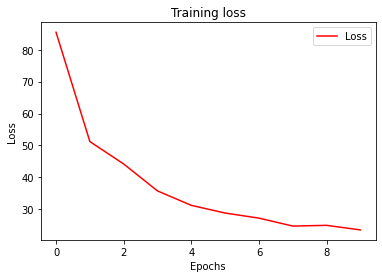

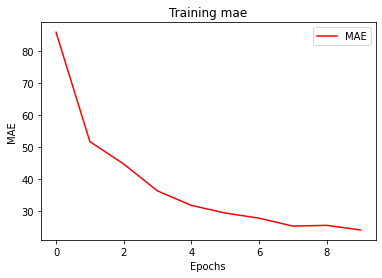

Running time: 5 Seconds


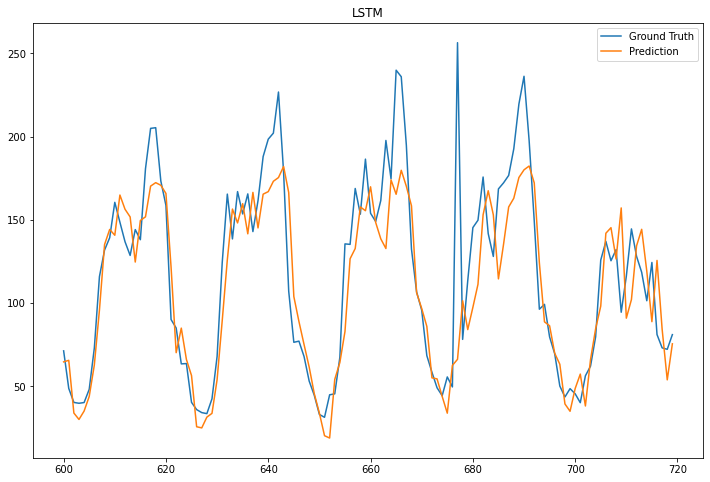

RMSE: 30.819335029496923
****************************************************************
当window_size为12，split_time为300
****************************************************************
Epoch 1/10
9/9 [==============================] - 3s 12ms/step - loss: 100.6749 - mae: 101.1734
Epoch 2/10
9/9 [==============================] - 0s 8ms/step - loss: 47.2318 - mae: 47.7293
Epoch 3/10
9/9 [==============================] - 0s 9ms/step - loss: 46.0424 - mae: 46.5410
Epoch 4/10
9/9 [==============================] - 0s 9ms/step - loss: 42.4048 - mae: 42.9026
Epoch 5/10
9/9 [==============================] - 0s 10ms/step - loss: 38.9517 - mae: 39.4492
Epoch 6/10
9/9 [==============================] - 0s 10ms/step - loss: 36.1982 - mae: 36.6943
Epoch 7/10
9/9 [==============================] - 0s 11ms/step - loss: 33.6126 - mae: 34.1099
Epoch 8/10
9/9 [==============================] - 0s 10ms/step - loss: 31.1631 - mae: 31.6583
Epoch 9/10
9/9 [==============================] - 0s 9ms/step -

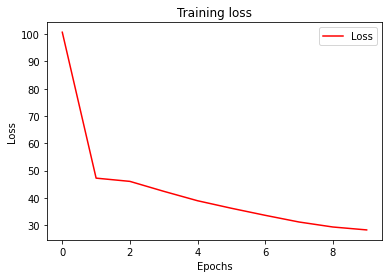

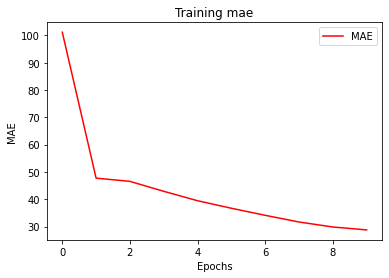

Running time: 6 Seconds


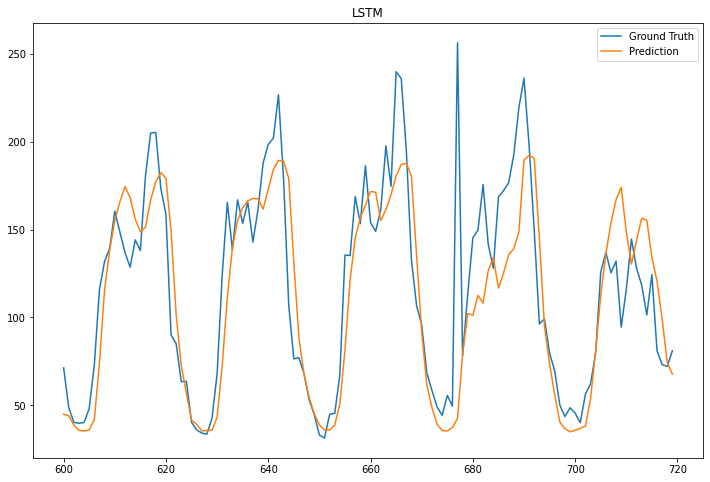

RMSE: 34.531618958478305
****************************************************************
当window_size为24，split_time为300
****************************************************************
Epoch 1/10
9/9 [==============================] - 3s 21ms/step - loss: 74.3246 - mae: 74.8233
Epoch 2/10
9/9 [==============================] - 0s 18ms/step - loss: 41.6258 - mae: 42.1234
Epoch 3/10
9/9 [==============================] - 0s 20ms/step - loss: 29.6734 - mae: 30.1694
Epoch 4/10
9/9 [==============================] - 0s 20ms/step - loss: 26.4542 - mae: 26.9502
Epoch 5/10
9/9 [==============================] - 0s 19ms/step - loss: 25.1669 - mae: 25.6622
Epoch 6/10
9/9 [==============================] - 0s 19ms/step - loss: 23.1578 - mae: 23.6514
Epoch 7/10
9/9 [==============================] - 0s 19ms/step - loss: 22.0123 - mae: 22.5061
Epoch 8/10
9/9 [==============================] - 0s 18ms/step - loss: 21.4884 - mae: 21.9819
Epoch 9/10
9/9 [==============================] - 0s 20ms/step

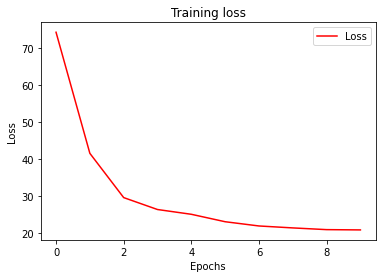

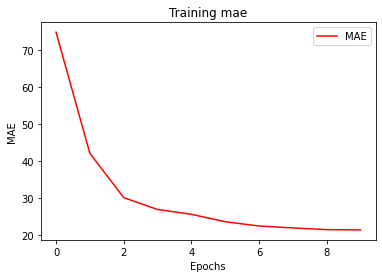

Running time: 9 Seconds


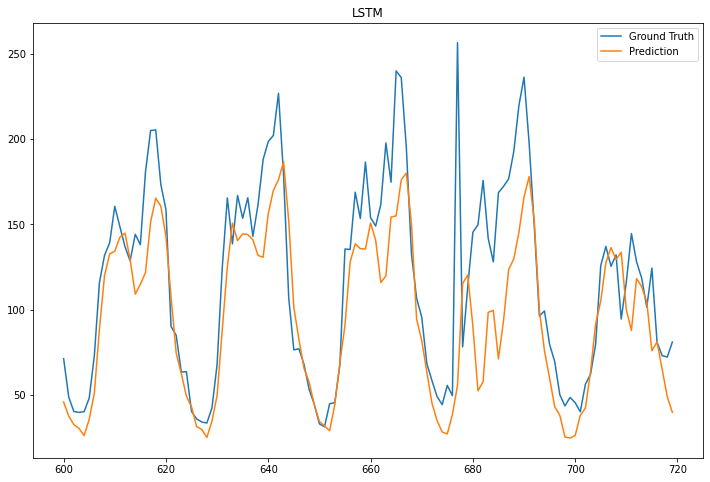

RMSE: 38.44338770916439
****************************************************************
当window_size为100，split_time为300
****************************************************************
Epoch 1/10
7/7 [==============================] - 3s 61ms/step - loss: 68.4787 - mae: 68.9772
Epoch 2/10
7/7 [==============================] - 0s 58ms/step - loss: 47.1630 - mae: 47.6599
Epoch 3/10
7/7 [==============================] - 0s 59ms/step - loss: 39.9810 - mae: 40.4785
Epoch 4/10
7/7 [==============================] - 0s 57ms/step - loss: 30.1315 - mae: 30.6276
Epoch 5/10
7/7 [==============================] - 0s 57ms/step - loss: 25.7849 - mae: 26.2786
Epoch 6/10
7/7 [==============================] - 0s 55ms/step - loss: 25.1042 - mae: 25.5985
Epoch 7/10
7/7 [==============================] - 0s 59ms/step - loss: 24.2665 - mae: 24.7603
Epoch 8/10
7/7 [==============================] - 0s 57ms/step - loss: 23.8312 - mae: 24.3247
Epoch 9/10
7/7 [==============================] - 0s 57ms/step

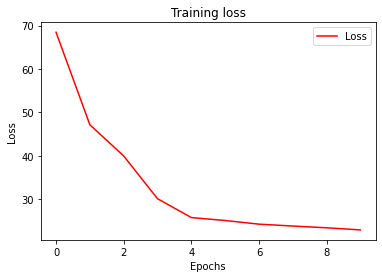

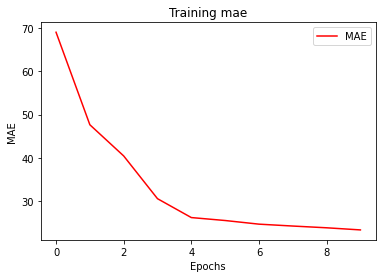

Running time: 16 Seconds


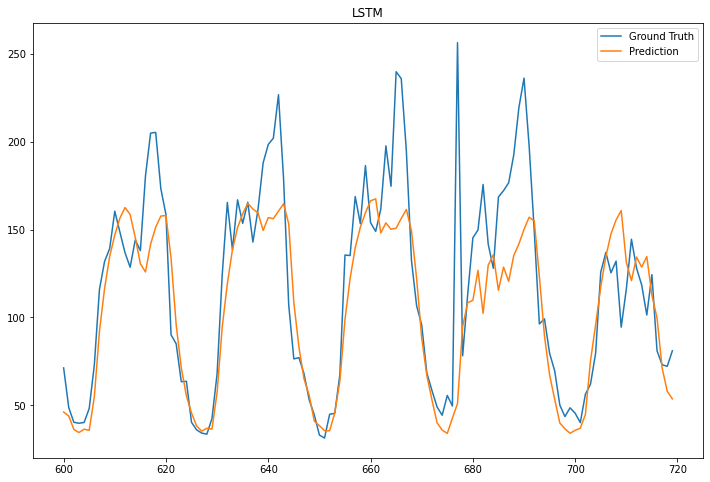

RMSE: 34.6020347082942
****************************************************************
当window_size为4，split_time为600
****************************************************************
Epoch 1/10
19/19 [==============================] - 3s 6ms/step - loss: 65.8590 - mae: 66.3571
Epoch 2/10
19/19 [==============================] - 0s 6ms/step - loss: 41.5912 - mae: 42.0891
Epoch 3/10
19/19 [==============================] - 0s 5ms/step - loss: 32.7781 - mae: 33.2757
Epoch 4/10
19/19 [==============================] - 0s 5ms/step - loss: 26.6624 - mae: 27.1574
Epoch 5/10
19/19 [==============================] - 0s 5ms/step - loss: 23.7065 - mae: 24.2020
Epoch 6/10
19/19 [==============================] - 0s 6ms/step - loss: 22.6222 - mae: 23.1179
Epoch 7/10
19/19 [==============================] - 0s 6ms/step - loss: 21.6043 - mae: 22.1004
Epoch 8/10
19/19 [==============================] - 0s 6ms/step - loss: 21.2318 - mae: 21.7260
Epoch 9/10
19/19 [==============================] - 0s 6m

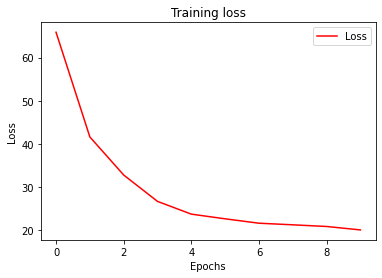

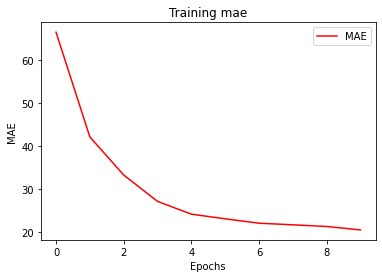

Running time: 6 Seconds


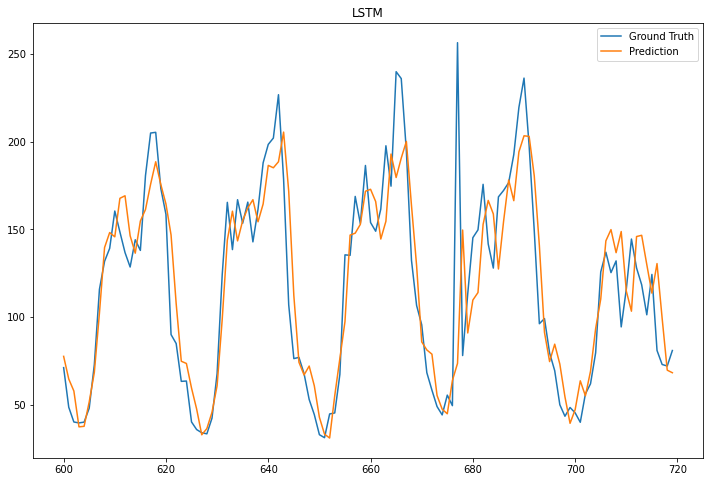

RMSE: 28.764167249756717
****************************************************************
当window_size为12，split_time为600
****************************************************************
Epoch 1/10
19/19 [==============================] - 3s 12ms/step - loss: 46.6525 - mae: 47.1503
Epoch 2/10
19/19 [==============================] - 0s 10ms/step - loss: 33.3983 - mae: 33.8956
Epoch 3/10
19/19 [==============================] - 0s 9ms/step - loss: 28.4992 - mae: 28.9952
Epoch 4/10
19/19 [==============================] - 0s 10ms/step - loss: 24.5134 - mae: 25.0078
Epoch 5/10
19/19 [==============================] - 0s 10ms/step - loss: 21.8673 - mae: 22.3612
Epoch 6/10
19/19 [==============================] - 0s 10ms/step - loss: 20.2198 - mae: 20.7131
Epoch 7/10
19/19 [==============================] - 0s 10ms/step - loss: 20.1600 - mae: 20.6536
Epoch 8/10
19/19 [==============================] - ETA: 0s - loss: 19.2985 - mae: 19.791 - 0s 9ms/step - loss: 19.3499 - mae: 19.8428
Epoch 9/

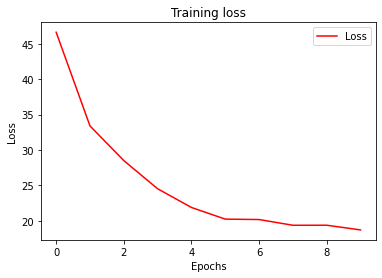

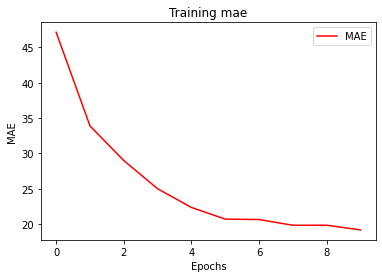

Running time: 9 Seconds


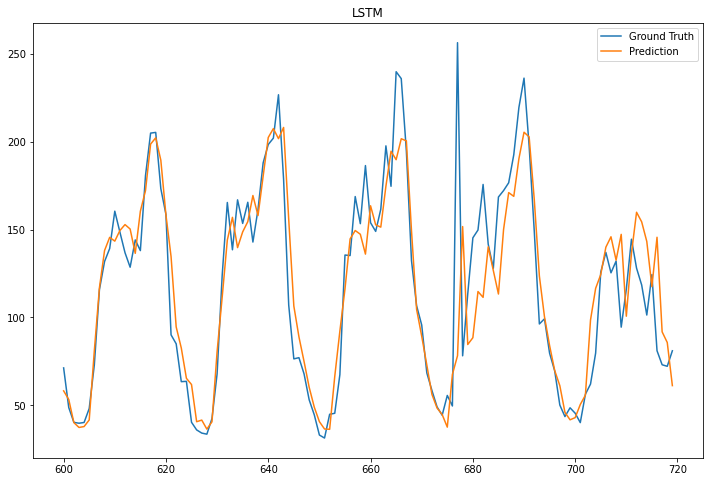

RMSE: 27.845301480577223
****************************************************************
当window_size为24，split_time为600
****************************************************************
Epoch 1/10
18/18 [==============================] - 3s 16ms/step - loss: 54.6342 - mae: 55.1317
Epoch 2/10
18/18 [==============================] - 0s 16ms/step - loss: 29.7052 - mae: 30.2006
Epoch 3/10
18/18 [==============================] - 0s 17ms/step - loss: 25.7550 - mae: 26.2494
Epoch 4/10
18/18 [==============================] - 0s 16ms/step - loss: 24.1757 - mae: 24.6699
Epoch 5/10
18/18 [==============================] - 0s 15ms/step - loss: 23.0223 - mae: 23.5164
Epoch 6/10
18/18 [==============================] - 0s 15ms/step - loss: 22.2167 - mae: 22.7109
Epoch 7/10
18/18 [==============================] - 0s 17ms/step - loss: 21.3860 - mae: 21.8799
Epoch 8/10
18/18 [==============================] - 0s 16ms/step - loss: 22.1570 - mae: 22.6513
Epoch 9/10
18/18 [============================

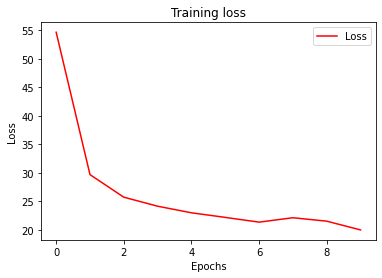

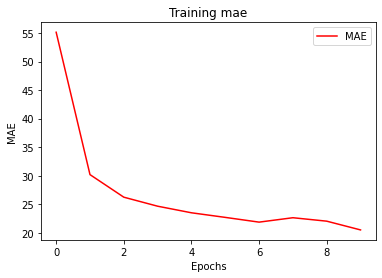

Running time: 12 Seconds


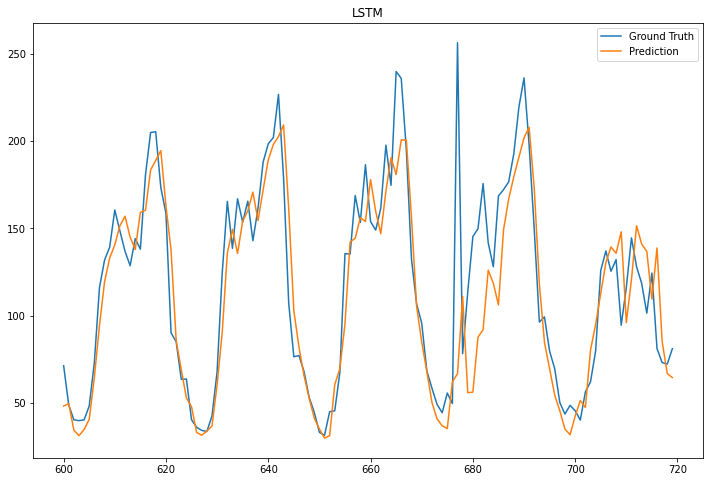

RMSE: 30.03186703037078
****************************************************************
当window_size为100，split_time为600
****************************************************************
Epoch 1/10
16/16 [==============================] - 3s 60ms/step - loss: 37.8296 - mae: 38.3263
Epoch 2/10
16/16 [==============================] - 1s 60ms/step - loss: 24.0455 - mae: 24.5399
Epoch 3/10
16/16 [==============================] - 1s 60ms/step - loss: 22.5769 - mae: 23.0704
Epoch 4/10
16/16 [==============================] - 1s 60ms/step - loss: 21.4839 - mae: 21.9776
Epoch 5/10
16/16 [==============================] - 1s 60ms/step - loss: 20.4965 - mae: 20.9894
Epoch 6/10
16/16 [==============================] - 1s 61ms/step - loss: 20.2863 - mae: 20.7796
Epoch 7/10
16/16 [==============================] - 1s 62ms/step - loss: 19.3736 - mae: 19.8663
Epoch 8/10
16/16 [==============================] - 1s 59ms/step - loss: 18.7789 - mae: 19.2702
Epoch 9/10
16/16 [============================

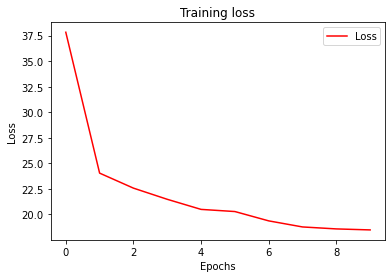

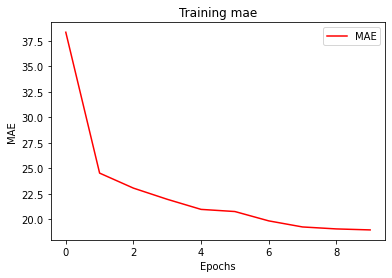

Running time: 34 Seconds


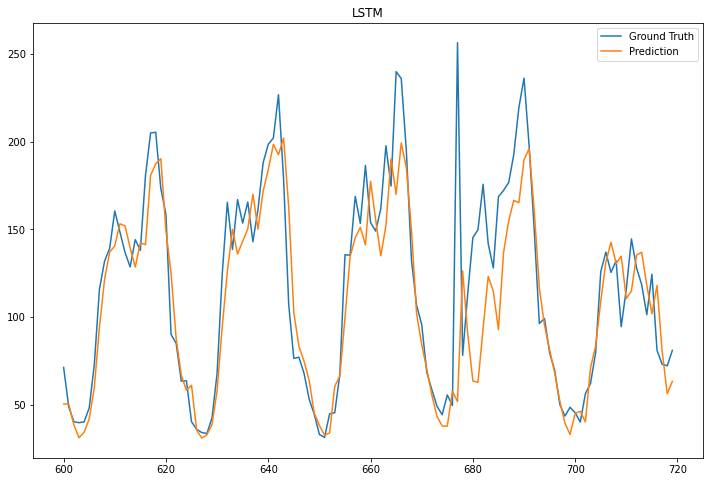

RMSE: 31.642204728663252


In [25]:
main(base_dataseries,4,300,time,t_time)
main(base_dataseries,12,300,time,t_time)
main(base_dataseries,24,300,time,t_time)
main(base_dataseries,100,300,time,t_time)
main(base_dataseries,4,600,time,t_time)
main(base_dataseries,12,600,time,t_time)
main(base_dataseries,24,600,time,t_time)
main(base_dataseries,100,600,time,t_time)

## （学生在此有工作）  

## (选作内容)对神经网络进行调参，只需要对模型训练函数进行修改即可

In [29]:
def model_train2(window_size,split_time,x_train,kernel_size,activation):
    window_size = window_size #可以尝试4 12 24 100
    split_time = split_time #可以尝试600 300
    
    start_time=time.process_time()
    batch_size = 32

    if split_time%3==0:
        shuffle_buffer_size = np.float64(split_time/3)
    else:
        shuffle_buffer_size = np.float64(split_time/2)
    tf.keras.backend.clear_session()
    #tf.random.set_seed(51)
    np.random.seed(51)
    train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer=shuffle_buffer_size)#得到经过时间窗切片的滑动窗口训练数据
    #定义模型
    model = tf.keras.models.Sequential([
      tf.keras.layers.Conv1D(filters=60, kernel_size=kernel_size,
                          strides=1, padding="causal",
                          activation="relu",
                          input_shape=[None, 1]),
      tf.keras.layers.LSTM(60, return_sequences=True),
      tf.keras.layers.LSTM(60, return_sequences=True),
      tf.keras.layers.Dense(30, activation=activation),
      tf.keras.layers.Dense(10, activation=activation),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 400)
    ])

    # lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    #     lambda epoch: 1e-8 * 10**(epoch / 20))
    optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)#优化器：SGD 学习率1e-5 （可调节） 
    model.compile(loss=tf.keras.losses.Huber(),#使用上文定义的基于LSTM的model结构，loss函数选为Huber损失，即平滑的平均绝对误差
                  optimizer=optimizer,
                  metrics=["mae"])
    history = model.fit(train_set,epochs=10)#训练伦次epochs (可调节)
    model.summary()
    return model,history,start_time
def main2(base_dataseries,time,t_time,kernel_size,activation):
    window_size=12
    split_time=600
    print("****************************************************************")
    print("当kernel_size为{}，activation为{}".format(kernel_size,activation))
    print("****************************************************************")
    #首先处理数据
    series,time,time_train,x_train,time_valid,x_valid=my_split_data(base_dataseries,split_time,time,t_time)
    #进行模型的训练
    model,history,start_time=model_train2(window_size,split_time,x_train,kernel_size,activation)
    #展示训练过程
    loss_and_mae(history)
    #进行模型预测
    rnn_forecast=time_fore(model,series,window_size,time_valid,start_time)
    #观察预测的流量值和RMESE
    foredata_and_rmes(time_valid, x_valid,rnn_forecast)

## 对激活函数进行调整和kernel_size进行调整，进行测试和性能比较

****************************************************************
当kernel_size为5，activation为relu
****************************************************************
Epoch 1/10
19/19 [==============================] - 3s 12ms/step - loss: 56.8891 - mae: 57.3867
Epoch 2/10
19/19 [==============================] - 0s 12ms/step - loss: 34.4546 - mae: 34.9515
Epoch 3/10
19/19 [==============================] - 0s 12ms/step - loss: 27.9646 - mae: 28.4602
Epoch 4/10
19/19 [==============================] - 0s 11ms/step - loss: 23.8268 - mae: 24.3212
Epoch 5/10
19/19 [==============================] - 0s 11ms/step - loss: 21.5553 - mae: 22.0487
Epoch 6/10
19/19 [==============================] - 0s 11ms/step - loss: 20.2134 - mae: 20.7058
Epoch 7/10
19/19 [==============================] - 0s 10ms/step - loss: 19.7219 - mae: 20.2140
Epoch 8/10
19/19 [==============================] - 0s 10ms/step - loss: 19.9865 - mae: 20.4787
Epoch 9/10
19/19 [==============================] - 0s 10ms/step - loss

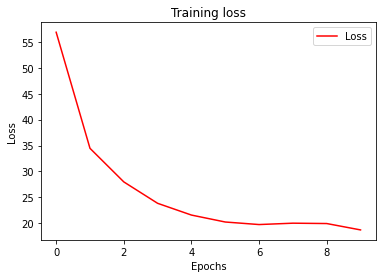

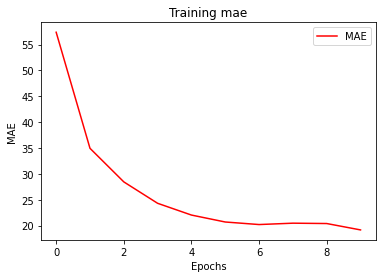

Running time: 10 Seconds


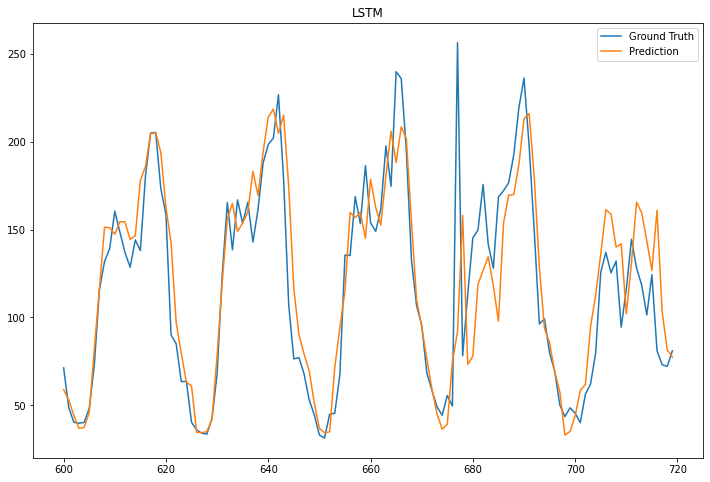

RMSE: 29.375177890264208
****************************************************************
当kernel_size为10，activation为relu
****************************************************************
Epoch 1/10
19/19 [==============================] - 3s 12ms/step - loss: 53.1108 - mae: 53.6091
Epoch 2/10
19/19 [==============================] - 0s 10ms/step - loss: 34.7805 - mae: 35.2769
Epoch 3/10
19/19 [==============================] - 0s 11ms/step - loss: 28.7549 - mae: 29.2509
Epoch 4/10
19/19 [==============================] - 0s 10ms/step - loss: 26.0828 - mae: 26.5781
Epoch 5/10
19/19 [==============================] - 0s 11ms/step - loss: 24.9074 - mae: 25.4023
Epoch 6/10
19/19 [==============================] - 0s 10ms/step - loss: 25.1229 - mae: 25.6185
Epoch 7/10
19/19 [==============================] - 0s 11ms/step - loss: 23.0655 - mae: 23.5603
Epoch 8/10
19/19 [==============================] - 0s 11ms/step - loss: 22.0131 - mae: 22.5078
Epoch 9/10
19/19 [===========================

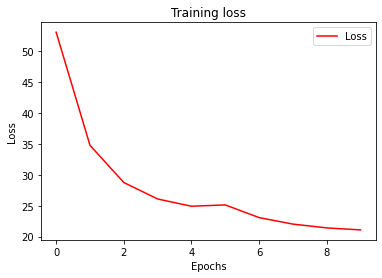

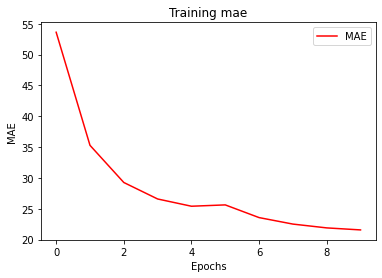

Running time: 9 Seconds


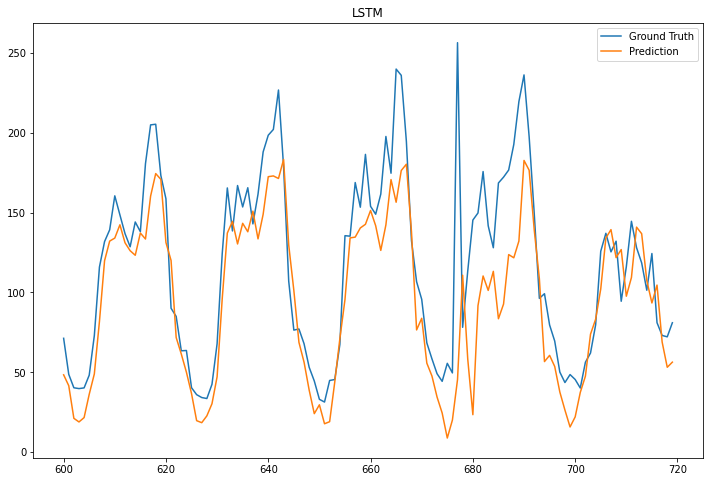

RMSE: 37.51331989601219
****************************************************************
当kernel_size为30，activation为relu
****************************************************************
Epoch 1/10
19/19 [==============================] - 3s 12ms/step - loss: 75.5183 - mae: 76.0171
Epoch 2/10
19/19 [==============================] - 0s 11ms/step - loss: 46.0206 - mae: 46.5171
Epoch 3/10
19/19 [==============================] - 0s 11ms/step - loss: 38.4353 - mae: 38.9324
Epoch 4/10
19/19 [==============================] - 0s 11ms/step - loss: 34.4066 - mae: 34.9028
Epoch 5/10
19/19 [==============================] - 0s 11ms/step - loss: 30.6881 - mae: 31.1831
Epoch 6/10
19/19 [==============================] - 0s 11ms/step - loss: 27.4410 - mae: 27.9363
Epoch 7/10
19/19 [==============================] - 0s 11ms/step - loss: 25.4571 - mae: 25.9512
Epoch 8/10
19/19 [==============================] - 0s 11ms/step - loss: 24.7038 - mae: 25.1990
Epoch 9/10
19/19 [============================

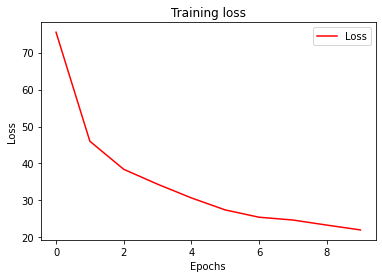

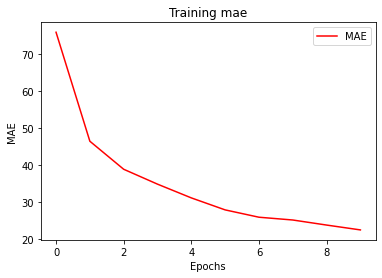

Running time: 9 Seconds


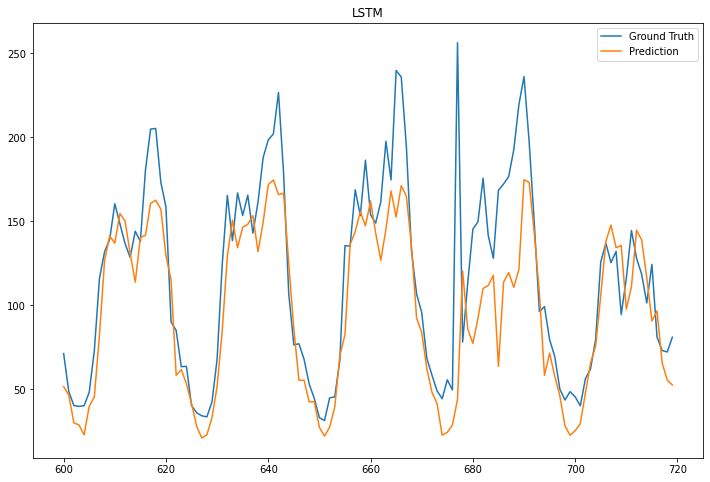

RMSE: 36.70197258303806
****************************************************************
当kernel_size为5，activation为sigmoid
****************************************************************
Epoch 1/10
19/19 [==============================] - 3s 12ms/step - loss: 189.7410 - mae: 190.2408
Epoch 2/10
19/19 [==============================] - 0s 10ms/step - loss: 70.4454 - mae: 70.9443
Epoch 3/10
19/19 [==============================] - 0s 10ms/step - loss: 49.6663 - mae: 50.1648
Epoch 4/10
19/19 [==============================] - 0s 10ms/step - loss: 45.3916 - mae: 45.8902
Epoch 5/10
19/19 [==============================] - 0s 10ms/step - loss: 44.0817 - mae: 44.5802
Epoch 6/10
19/19 [==============================] - 0s 10ms/step - loss: 42.9571 - mae: 43.4552
Epoch 7/10
19/19 [==============================] - 0s 10ms/step - loss: 41.9432 - mae: 42.4418
Epoch 8/10
19/19 [==============================] - 0s 10ms/step - loss: 39.9483 - mae: 40.4468
Epoch 9/10
19/19 [========================

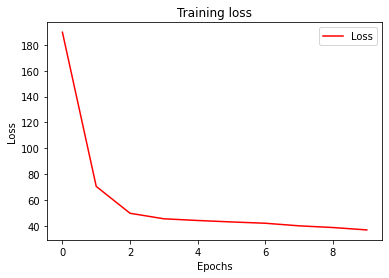

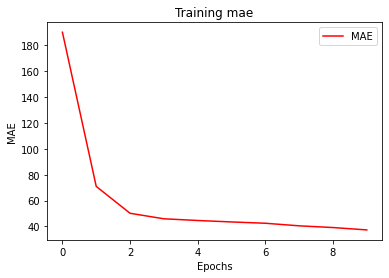

Running time: 9 Seconds


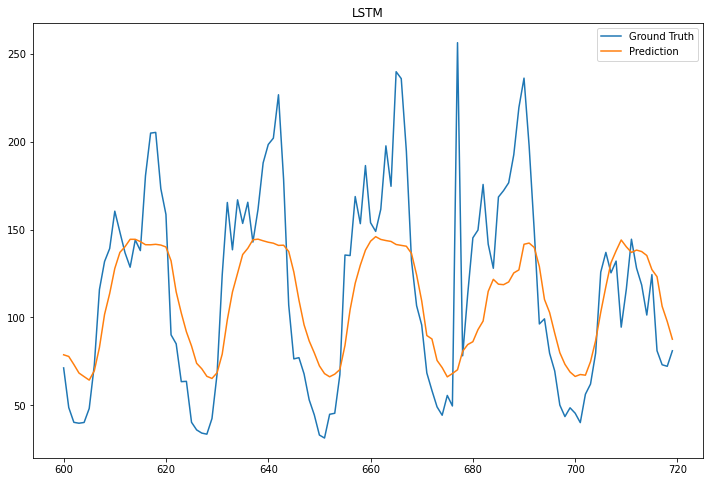

RMSE: 41.382089207619075
****************************************************************
当kernel_size为10，activation为sigmoid
****************************************************************
Epoch 1/10
19/19 [==============================] - 3s 12ms/step - loss: 72.6296 - mae: 73.1276
Epoch 2/10
19/19 [==============================] - 0s 10ms/step - loss: 51.9331 - mae: 52.4309
Epoch 3/10
19/19 [==============================] - 0s 10ms/step - loss: 48.6444 - mae: 49.1427
Epoch 4/10
19/19 [==============================] - 0s 9ms/step - loss: 47.7379 - mae: 48.2363
Epoch 5/10
19/19 [==============================] - 0s 10ms/step - loss: 47.1418 - mae: 47.6400
Epoch 6/10
19/19 [==============================] - 0s 10ms/step - loss: 46.8344 - mae: 47.3330
Epoch 7/10
19/19 [==============================] - 0s 10ms/step - loss: 46.7299 - mae: 47.2286
Epoch 8/10
19/19 [==============================] - 0s 10ms/step - loss: 45.9839 - mae: 46.4825
Epoch 9/10
19/19 [=========================

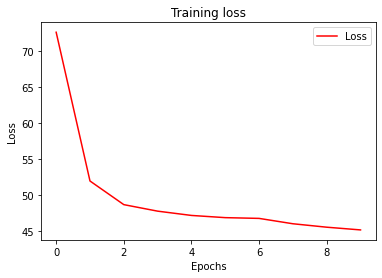

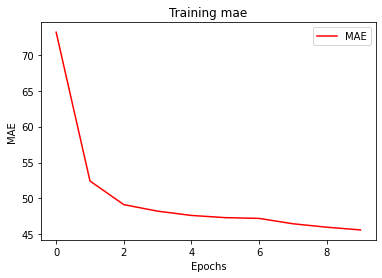

Running time: 9 Seconds


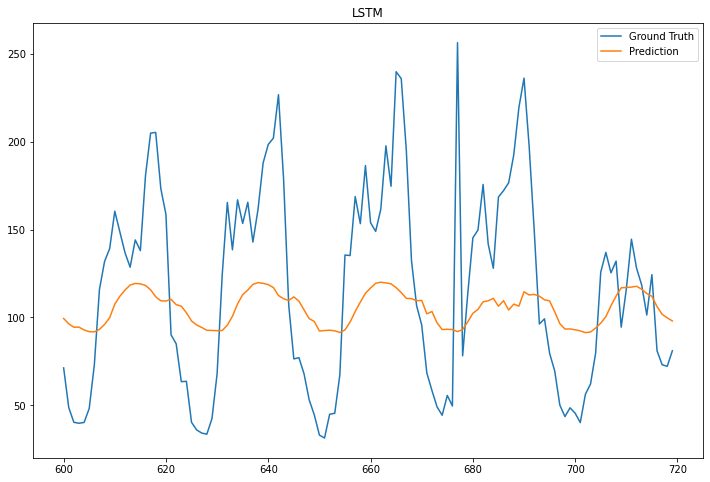

RMSE: 53.180854490862316
****************************************************************
当kernel_size为30，activation为sigmoid
****************************************************************
Epoch 1/10
19/19 [==============================] - 3s 11ms/step - loss: 49.1090 - mae: 49.6070
Epoch 2/10
19/19 [==============================] - 0s 10ms/step - loss: 43.7625 - mae: 44.2607
Epoch 3/10
19/19 [==============================] - 0s 11ms/step - loss: 39.8466 - mae: 40.3442
Epoch 4/10
19/19 [==============================] - 0s 11ms/step - loss: 36.8666 - mae: 37.3639
Epoch 5/10
19/19 [==============================] - 0s 10ms/step - loss: 34.7741 - mae: 35.2706
Epoch 6/10
19/19 [==============================] - 0s 11ms/step - loss: 35.0150 - mae: 35.5111
Epoch 7/10
19/19 [==============================] - 0s 11ms/step - loss: 32.2289 - mae: 32.7253
Epoch 8/10
19/19 [==============================] - 0s 10ms/step - loss: 30.6598 - mae: 31.1556
Epoch 9/10
19/19 [========================

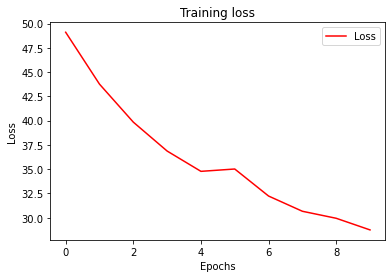

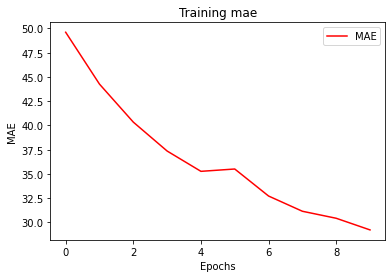

Running time: 9 Seconds


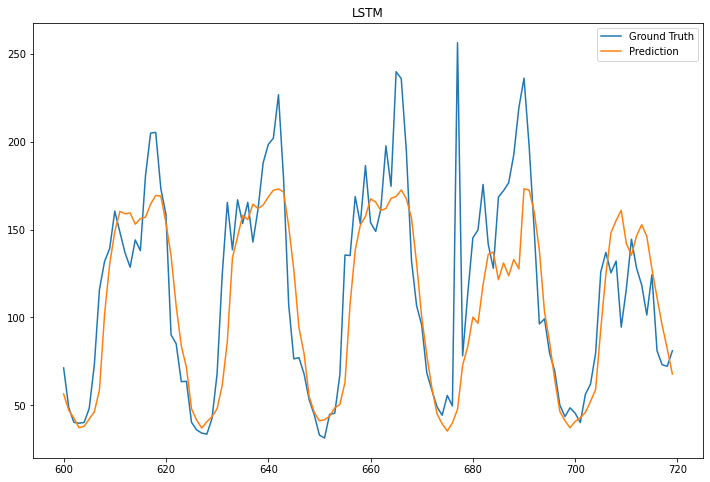

RMSE: 35.242869657155914
****************************************************************
当kernel_size为5，activation为tanh
****************************************************************
Epoch 1/10
19/19 [==============================] - 3s 11ms/step - loss: 59.2155 - mae: 59.7137
Epoch 2/10
19/19 [==============================] - 0s 10ms/step - loss: 28.8415 - mae: 29.3377
Epoch 3/10
19/19 [==============================] - 0s 10ms/step - loss: 26.0032 - mae: 26.4986
Epoch 4/10
19/19 [==============================] - 0s 10ms/step - loss: 23.5707 - mae: 24.0662
Epoch 5/10
19/19 [==============================] - 0s 10ms/step - loss: 21.3702 - mae: 21.8642
Epoch 6/10
19/19 [==============================] - 0s 11ms/step - loss: 21.4232 - mae: 21.9175
Epoch 7/10
19/19 [==============================] - 0s 10ms/step - loss: 25.0485 - mae: 25.5446
Epoch 8/10
19/19 [==============================] - 0s 10ms/step - loss: 24.3163 - mae: 24.8113
Epoch 9/10
19/19 [============================

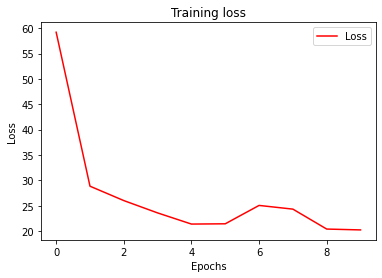

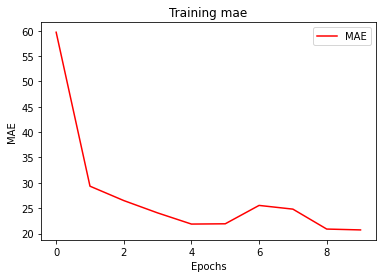

Running time: 9 Seconds


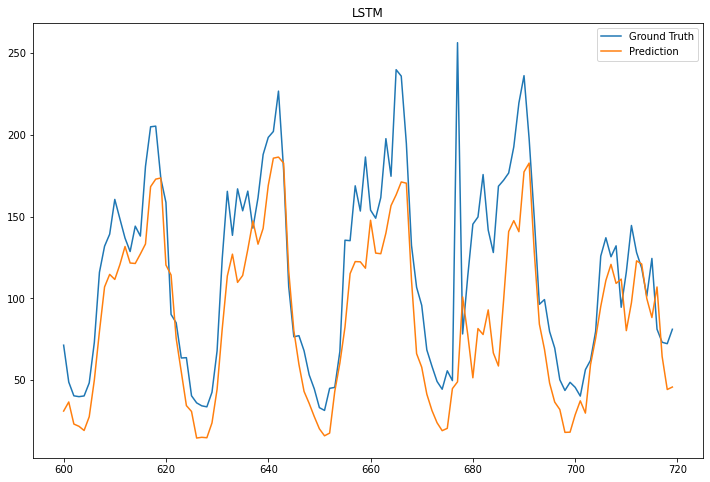

RMSE: 40.358601622237735
****************************************************************
当kernel_size为10，activation为tanh
****************************************************************
Epoch 1/10
19/19 [==============================] - 3s 10ms/step - loss: 37.5291 - mae: 38.0267
Epoch 2/10
19/19 [==============================] - 0s 10ms/step - loss: 26.3345 - mae: 26.8301
Epoch 3/10
19/19 [==============================] - 0s 11ms/step - loss: 23.6379 - mae: 24.1323
Epoch 4/10
19/19 [==============================] - 0s 11ms/step - loss: 22.6644 - mae: 23.1588
Epoch 5/10
19/19 [==============================] - 0s 10ms/step - loss: 22.1392 - mae: 22.6343
Epoch 6/10
19/19 [==============================] - 0s 10ms/step - loss: 20.7642 - mae: 21.2585
Epoch 7/10
19/19 [==============================] - 0s 10ms/step - loss: 20.1708 - mae: 20.6650
Epoch 8/10
19/19 [==============================] - 0s 10ms/step - loss: 20.2694 - mae: 20.7630
Epoch 9/10
19/19 [===========================

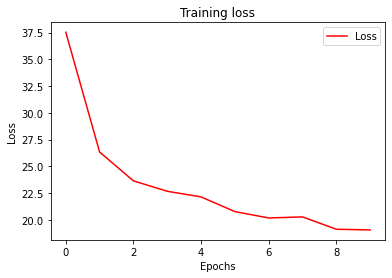

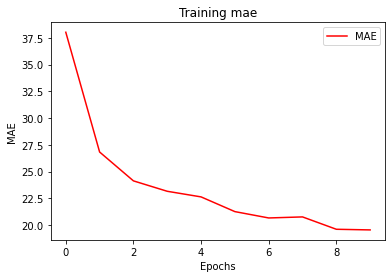

Running time: 9 Seconds


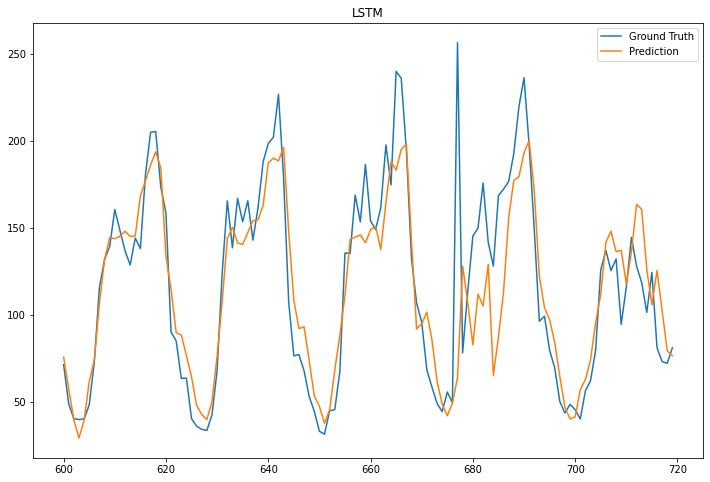

RMSE: 30.130876588948745
****************************************************************
当kernel_size为30，activation为tanh
****************************************************************
Epoch 1/10
19/19 [==============================] - 3s 12ms/step - loss: 47.2060 - mae: 47.7038
Epoch 2/10
19/19 [==============================] - 0s 11ms/step - loss: 28.9096 - mae: 29.4054
Epoch 3/10
19/19 [==============================] - 0s 10ms/step - loss: 25.2086 - mae: 25.7030
Epoch 4/10
19/19 [==============================] - 0s 10ms/step - loss: 23.5409 - mae: 24.0359
Epoch 5/10
19/19 [==============================] - 0s 10ms/step - loss: 21.3801 - mae: 21.8755
Epoch 6/10
19/19 [==============================] - 0s 10ms/step - loss: 23.9728 - mae: 24.4673
Epoch 7/10
19/19 [==============================] - 0s 10ms/step - loss: 24.4533 - mae: 24.9489
Epoch 8/10
19/19 [==============================] - 0s 10ms/step - loss: 20.6823 - mae: 21.1764
Epoch 9/10
19/19 [===========================

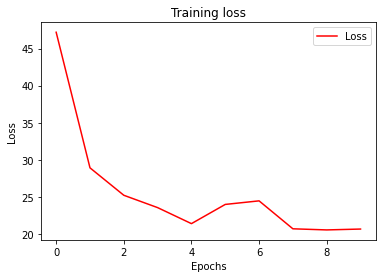

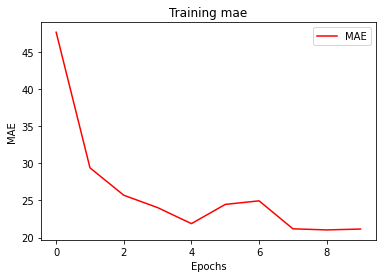

Running time: 9 Seconds


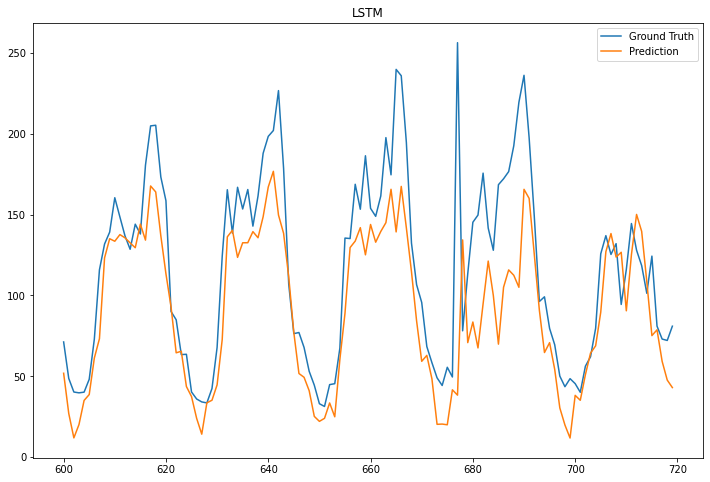

RMSE: 40.68342048716313


In [30]:
main2(base_dataseries,time,t_time,5,'relu')
main2(base_dataseries,time,t_time,10,'relu')
main2(base_dataseries,time,t_time,30,'relu')
main2(base_dataseries,time,t_time,5,'sigmoid')
main2(base_dataseries,time,t_time,10,'sigmoid')
main2(base_dataseries,time,t_time,30,'sigmoid')
main2(base_dataseries,time,t_time,5,'tanh')
main2(base_dataseries,time,t_time,10,'tanh')
main2(base_dataseries,time,t_time,30,'tanh')

## （学生在此有工作）
## 结果分析
### 改变split_time和window_size的结果分析（必做）
![lstm](SW.png)  
#### 由上图可见，当split_time=600时，性能远优于300时，但是MASE和window_size的关系则并非线性关系，但是算法运行时间是随着window_size的增大而变大。在诸多组合中表现最好的是split_time=600和window_size=12；表现最差的是split_time=300和window_size=24；结合图像可见，loss和mae的数值相近，并且变化趋势一致，均是先快速降低然后缓慢收敛，可预测知并非一味提高迭代次数便能够提高算法性能。
### 改变split_time和window_size的结果分析（选作）
![lstm](KA.png)
#### 由上图可见，激活函数为Relu时，算法性能普遍优于另外两种激活函数（除了tanh在K_size为10时也表现出了极好的性能）；但是K_size和算法的性能关系则不明显，存在波动，这也是机器学习的不可解释性。在时间方面，K_size和激活函数的改变对算法运行时间无较大影响。在诸多组合中，激活函数为Relu，K_size为5时算法性能最好；激活函数为sigmoid，K_size为10时算法性能最好；此外值得注意的是，当激活函数为tanh时，loss和MAE的曲线随着迭代次数的增加出现了波动，有反常增加不收敛的情况存在。

## 学习心得和课程建议
### 经过参数的调试，让我清楚的认到调参的重要性，仅仅几个数值的变化却可以对性能有极大的影响；但是同时也认识到了调参的难度，不可解释，不规律变化，让如何调参成为了一个问题；此外我也认识到了数据处理会对模型性能可能产生的影响。最后，通过本次实验认识到了机器学习如何应用在解决本专业的实际问题中，学习到了时序预测算法LSTM，也认识到了预测对于解决问题的作用和意义。